In [12]:
from PIL import Image
from wand.image import Image as wandImage
from wand.color import Color
import cv2
import PyPDF2
import pytesseract
import argparse
import os
import io
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tempfile
import mrjob
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,30)

In [16]:
def pdfPageToImg(src_pdf, pagenum, resolution=300, preprocess="thresh"):

#    src_pdf = PyPDF2.PdfFileReader(filename)
    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))
    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    img_buffer=None

    with wandImage(file = pdf_bytes, resolution = resolution) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    return Image.fromarray(gray)

In [3]:
def ocr(image, verbose=True, debug=False):
    # load the image as a PIL/Pillow image, apply OCR
    pagecontents = {}
    data = pytesseract.image_to_data(image, output_type="df.frame")
    boxes = pytesseract.image_to_boxes(image)
    try:
        df = pd.read_csv(io.StringIO(data), sep="\t", quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')
        dfm = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        df = dfm.set_index(["block_num","par_num"])
        blockstats = {'block':[], 'n_par':[], 'n_line':[], 'top_at':[], 'bottom_at':[], 'left_at':[], 'right_at':[]}
        paragraphs = {}
        for block in df.index.levels[0]:
            blockstats['block'].append(block)
            blockstats['n_par'].append(len(np.unique(df.loc[block,].index.values)))
            blockstats['n_line'].append(df.loc[(block,)]['top'].count())
            blockstats['top_at'].append(min(df.loc[(block,)]['top']))
            blockstats['bottom_at'].append(max(df.loc[(block,)]['top']+df.loc[(block,)]['height']))
            blockstats['left_at'].append(min(df.loc[(block,)]['left']))
            blockstats['right_at'].append(max(df.loc[(block,)]['left']+df.loc[(block,)]['width']))
            paragraphs[block] = []
            for i in df.loc[block].index.unique():
                paragraphs[block].append(' '.join(list(map(lambda x: x.strip(), df.loc[block].loc[i,'text']))))
        blockstats = pd.DataFrame(data=blockstats).set_index('block')
        pagecontents['blockstats'] = blockstats
        pagecontents['paragraphs'] = paragraphs
    except:
        print("exception")

    if debug == True:
        tmp = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
        imgfilename = tmp[1]
        print(imgfilename)
        pagecontents['filename'] = imgfilename
        image.save(imgfilename)
       
    if verbose == True:
        pagecontents['data'] = dfm
        pagecontents['boxes'] = pd.read_csv(io.StringIO(boxes), quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python',
                                            sep="\s", header=None, names=["character", "x1","y1","x2","y2","c"])

    return pagecontents

In [17]:
def showImage(all_pages, pagecontents, pagenum=250, preprocess="thresh"):

    with wandImage(all_pages.sequence[pagenum]) as img:
        img.format = "png"
        img.alpha_channel = False
        img_buffer=np.asarray(bytearray(img.make_blob()), dtype=np.uint8)

    if img_buffer is not None:
        retval = cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(retval, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if preprocess == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    elif preprocess == "blur":
        gray = cv2.medianBlur(gray, 3)

    blockstats = pagecontents[pagenum]['blockstats']

    h, w = gray.shape
    img_blocks = gray.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    return img_blocks

# show the output image with block bounding boxes
# plt.imshow(img_blocks,cmap='gray')
# plt.show()

In [8]:
pagecontents = pickle.load(open( "Langley1863.p", "rb" ) )
pageimages = wandImage(filename="Langley1863.image", resolution=300)

In [26]:
isdirectory = [False]*len(pageimages.sequence)
for i in range(123, 469):
    isdirectory[i] = True

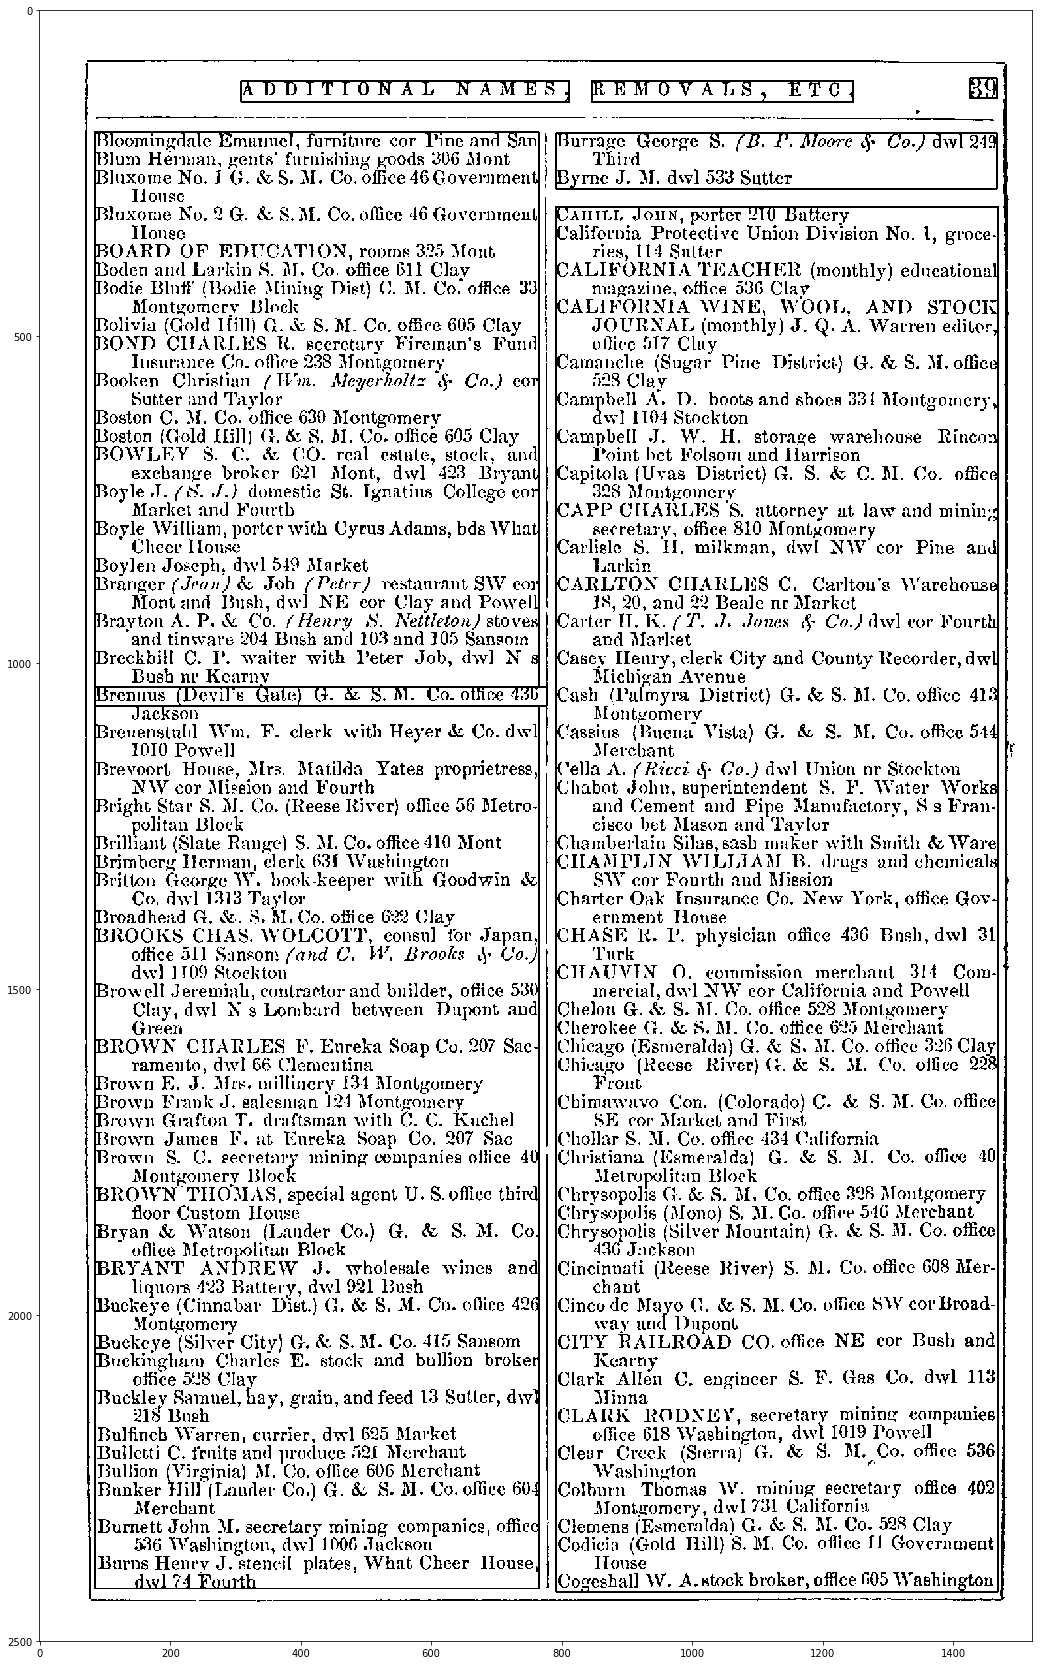

In [111]:
img = showImage(pageimages, pagecontents, pagenum=124)
plt.imshow(img, cmap="gray")

In [49]:
blockstats = {key: pagecontents[key].get('blockstats', None) for key in pagecontents.keys()}

In [67]:
blockstats[124]

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,
2,1,2,109,140,309,812
3,20,204,187,1037,85,765
4,1,11,1037,1066,85,777
5,32,285,1066,2419,86,766
9,1,2,109,141,846,1247
10,1,17,188,274,792,1467
11,1,1,104,135,1426,1467
12,43,447,301,2424,792,1468


In [112]:
blockstats[124][(blockstats[124].right_at < blockstats[124].right_at.max()*0.75) & (blockstats[124].n_line > 2)]

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,
3,20,204,187,1037,85,765
4,1,11,1037,1066,85,777
5,32,285,1066,2419,86,766


In [113]:
blockstats[124][(blockstats[124].right_at > blockstats[124].right_at.max()*0.75) & (blockstats[124].n_line > 2)]

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,
10,1,17,188,274,792,1467
12,43,447,301,2424,792,1468


In [114]:
blockstats[124][(blockstats[124].bottom_at < blockstats[124].bottom_at.max()*0.1) & (blockstats[124].n_line < 3)]

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,
2,1,2,109,140,309,812
9,1,2,109,141,846,1247
11,1,1,104,135,1426,1467


In [115]:
blockstats[124][(blockstats[124].top_at > blockstats[124].bottom_at.max()*0.8) & (blockstats[124].n_line < 3)]

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,


In [174]:
def categorizeTwoColumnBlocks(contents):
    block = contents['blockstats']
    text = contents['paragraphs']
    center = block.right_at.max()
    header = block[(block.bottom_at < block.bottom_at.max()*0.1) & (block.n_line < 3)].sort_values(by='left_at')
    leftcol = block[(block.right_at < block.right_at.max()*0.75) & (block.n_line > 2)].sort_values(by='left_at')
    rightcol = block[(block.right_at > block.right_at.max()*0.75) & (block.n_line > 2)].sort_values(by='top_at')
    footer = block[(block.top_at > block.bottom_at.max()*0.8) & (block.n_line < 3)].sort_values(by='top_at')

    blockstats = {'header':header,'footer':footer,'leftcol':leftcol,'rightcol':rightcol}
    
    paragraphs = {'header':list(itertools.chain.from_iterable([text[i] for i in header.index])),
                  'footer':list(itertools.chain.from_iterable([text[i] for i in footer.index])),
                  'leftcol':list(itertools.chain.from_iterable([text[i] for i in leftcol.index])),
                  'rightcol':list(itertools.chain.from_iterable([text[i] for i in rightcol.index]))
                 }
    
    return {'blockstats':blockstats, 'paragraphs':paragraphs}

In [ ]:
# define header as n_line < 3, bottom_at < 0.1 max bottom
#        footer as n_line < 3, top_at > 0.8 max bottom
#        leftcol as n_line > 3, left_at < 1/2 max right_at
#        rightcol as n_line > 3, right_at > 1/2 max right_at

In [175]:
categorizeTwoColumnBlocks(pagecontents[124])

{'blockstats': {'header':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  2          1       2     109        140      309       812
  9          1       2     109        141      846      1247
  11         1       1     104        135     1426      1467,
  'footer': Empty DataFrame
  Columns: [n_par, n_line, top_at, bottom_at, left_at, right_at]
  Index: [],
  'leftcol':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  3         20     204     187       1037       85       765
  4          1      11    1037       1066       85       777
  5         32     285    1066       2419       86       766,
  'rightcol':        n_par  n_line  top_at  bottom_at  left_at  right_at
  block                                                     
  10         1      17     188        274      792      1467
  12        43     447     301       2424      792  

In [173]:
import itertools
list(itertools.chain.from_iterable([pagecontents[124]['paragraphs'][i] for i in [2,3,5]]))

['ADDITIONAL NAMES,',
 'Bloomingdale Emanuel, furniture cor Pine and San',
 'Blum Herman, gents’ furnishing goods 306 Mont',
 'Bluxome No. J G. & 8. M. Co. office 46 Government Tiouse',
 'Bluxome No. 2G. & S.M. Co. office 46 Government',
 'o n s e',
 'BOARD OF EDUCATION, rooms 325 Mont',
 'Boden and Larkin S. M. Co. office 611 Clay',
 'Bodie Bluff (Bodie Mining Dist) C. M. Co. office 33 Montgomery Block',
 'Bolivia (Gold Till) G. & S. M. Co. office 605 Clay',
 "BOND CILARLES R. secretary Fireman's Fund Insurance Co. office 238 Montgomery",
 'Booken Christian (Wm. Meyerholtz §+ Co.) cor Sutter and Taylor',
 'Boston C. M. Co. office 630 Montgomery',
 'Boston (Gold Hill) G. & 8. M. Co. office 605 Clay',
 'BOWLEY 8. C. & CO. real estate, stock, and exchange broker 621 Mont, dwl 423 Bryant',
 'Boyle J. (8. J.) domestic St. Ignatius College cor Market and Fourth',
 'Boyle William, porter with Cyrus Adams, bds What Cheer Honse',
 'Boylen Joseph, dw] 549 Market',
 'Branger (Jean) & Job (Peter)

In [171]:
[pagecontents[124]['paragraphs'][i] for i in [2,3,5]]

[['ADDITIONAL NAMES,'],
 ['Bloomingdale Emanuel, furniture cor Pine and San',
  'Blum Herman, gents’ furnishing goods 306 Mont',
  'Bluxome No. J G. & 8. M. Co. office 46 Government Tiouse',
  'Bluxome No. 2G. & S.M. Co. office 46 Government',
  'o n s e',
  'BOARD OF EDUCATION, rooms 325 Mont',
  'Boden and Larkin S. M. Co. office 611 Clay',
  'Bodie Bluff (Bodie Mining Dist) C. M. Co. office 33 Montgomery Block',
  'Bolivia (Gold Till) G. & S. M. Co. office 605 Clay',
  "BOND CILARLES R. secretary Fireman's Fund Insurance Co. office 238 Montgomery",
  'Booken Christian (Wm. Meyerholtz §+ Co.) cor Sutter and Taylor',
  'Boston C. M. Co. office 630 Montgomery',
  'Boston (Gold Hill) G. & 8. M. Co. office 605 Clay',
  'BOWLEY 8. C. & CO. real estate, stock, and exchange broker 621 Mont, dwl 423 Bryant',
  'Boyle J. (8. J.) domestic St. Ignatius College cor Market and Fourth',
  'Boyle William, porter with Cyrus Adams, bds What Cheer Honse',
  'Boylen Joseph, dw] 549 Market',
  'Branger 

In [176]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  4


In [208]:
pages = []
args = {"filename": "1863Langley/1863Langley.pdf", "resolution": 300, "preprocess": "thresh"}
src_pdf = PyPDF2.PdfFileReader(args['filename'])
num_pages = src_pdf.getNumPages()
num_cpus = multiprocessing.cpu_count()
for i in range(multiprocessing.cpu_count()):
    pages.append(list(range(i, num_pages, num_cpus)))


In [205]:
print(list(range(3, num_pages, num_cpus)))

[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 267, 271, 275, 279, 283, 287, 291, 295, 299, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 379, 383, 387, 391, 395, 399, 403, 407, 411, 415, 419, 423, 427, 431, 435, 439, 443, 447, 451, 455, 459, 463, 467, 471, 475, 479, 483, 487, 491, 495, 499, 503, 507, 511, 515, 519, 523, 527, 531, 535, 539, 543, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 615, 619, 623, 627, 631, 635, 639, 643, 647, 651, 655, 659, 663, 667, 671, 675, 679]


In [216]:
max(pages[3])

679

In [198]:
num_pages

682